In [26]:
from VQ_Loss_Plotter import VQ_Loss_Plotter
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dataloader.asimow_dataloader import ASIMoWDataModule
from dataloader.utils import (
    get_vd_val_test_ids, 
    get_vs_val_test_ids, 
    get_inv_vs_val_test_ids, 
    get_inv_vd_val_test_ids,
    get_experiment_ids
)
from dataloader.asimow_dataloader import DataSplitId

In [27]:
plotter = VQ_Loss_Plotter()

In [28]:
def get_cycle_counts(test_ids):
    batch_size=512
    val_ids = (tuple(list(test_ids)[0]),)
    test_ids = tuple(list(test_ids)[1:])
    val_ids = [DataSplitId(experiment=e, welding_run=w) for e, w in val_ids]
    test_ids = [DataSplitId(experiment=e, welding_run=w) for e, w in test_ids]
    data_module = ASIMoWDataModule(
        task="reconstruction",
        batch_size=batch_size,
        n_cycles=1,
        val_data_ids=val_ids,
        test_data_ids=test_ids,
    )
    data_module.setup(stage="fit")
    train_loader_size = len(data_module.train_ds) 
    test_loader_size = len(data_module.test_ds) + len(data_module.val_ds)
    return train_loader_size, test_loader_size

In [29]:
def plot_current_voltage(current: np.ndarray, 
                         voltage: np.ndarray, 
                         filename, title: str, 
                         figsize=(14, 6), 
                         legend=True,
                         path='images/Raw/'):
    """
    Plots the current and voltage data on a single graph using Seaborn for styling.
 
    Parameters:
    current (np.ndarray): Array of current values.
    voltage (np.ndarray): Array of voltage values.
    title (str): Title of the plot.
    figsize (tuple, optional): Figure size in inches. Defaults to (14, 6).
    """
    
    # Set the Seaborn theme
    sns.set_theme(style="whitegrid")
    
    # Create the plot
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Plotting the current on the first axis
    color = 'tab:blue'
    line1, = ax1.plot(current, label="Current", color=color)
    ax1.set_ylabel("Current", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Creating a twin axis for voltage
    ax2 = ax1.twinx()
    color = 'tab:red'
    line2, = ax2.plot(voltage, label="Voltage", color=color)
    ax2.set_ylabel("Voltage", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Combining the legends from both axes
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    if legend:
        ax1.legend(lines, labels, loc='upper left')
    # Setting the title and the x-label
    plt.title(title)
    ax1.set_xlabel("Time")
    plt.tight_layout()
    plt.savefig(f'{path}{filename}', dpi=500)
    
    plt.show()

# Example usage (assuming current and voltage are defined numpy arrays)
# plot_current_voltage_sns(current, voltage, "Current vs Voltage")

In [30]:
def raw_plot(ex, run_id, start, end, filename):
    df = pd.read_pickle(f'raw_chunks/experiment_{ex}.pkl')
    start = round(start)
    end = round(end)
    run = df[df['welding_run'] == run_id]
    current = run['I'].to_numpy()[start:end]
    voltage = run['V'].to_numpy()[start:end]
    plot_current_voltage(
        current=current, 
        voltage=voltage, 
        title="",
        filename=filename,
    )



In [31]:
def plot_noise():
    random = pd.DataFrame(plotter.get_noise_data()[0][0].numpy())
    plot_current_voltage(
        current=random[0].to_numpy(), 
        voltage=random[1].to_numpy(), 
        title="",
        figsize=(8, 4),
        filename='RandomCycle.png',
        legend=False
    )
# raw_plot(1, 21, 2.002e5, 2.052e5, 'ex_1_21.png')

In [38]:
def get_dataset_sizes():
    all_runs = get_experiment_ids(1) + get_experiment_ids(2) + get_experiment_ids(3)
    vs_test = get_vs_val_test_ids()['test_ids']
    vs_val = get_vs_val_test_ids()['val_ids']
    vd_test = get_vd_val_test_ids()['test_ids']
    vd_val = get_vd_val_test_ids()['val_ids']
    inv_vs_test = get_inv_vs_val_test_ids()['test_ids']
    inv_vs_val = get_inv_vs_val_test_ids()['val_ids']
    inv_vd_test = get_inv_vd_val_test_ids()['test_ids']
    inv_vd_val = get_inv_vd_val_test_ids()['val_ids']
    subsets = [vs_test, vs_val, vd_test, vd_val, inv_vs_test, inv_vs_val, inv_vd_test, inv_vd_val]
    vs_test = [run for run in subsets[0] if run in all_runs]
    vs_val = [run for run in subsets[1] if run in all_runs]
    vd_test = [run for run in subsets[2] if run in all_runs]
    vd_val = [run for run in subsets[3] if run in all_runs]
    inv_vs_test = [run for run in subsets[4] if run in all_runs]
    inv_vs_val = [run for run in subsets[5] if run in all_runs]
    inv_vd_test = [run for run in subsets[6] if run in all_runs]
    inv_vd_val = [run for run in subsets[7] if run in all_runs]
    # print(len(all_runs))
    # print(len(get_experiment_ids(1) +  get_experiment_ids(2)))
    # print(len(get_experiment_ids(3)))
    n_all = len(all_runs)

    n_vs_test = len(vs_test)
    n_vs_val = len(vs_val)

    n_vd_test = len(vd_test)
    n_vd_val = len(vd_val)

    n_inv_vs_test = len(inv_vs_test)
    n_inv_vs_val = len(inv_vs_val)

    n_inv_vd_test = len(inv_vd_test)
    n_inv_vd_val = len(inv_vd_val)

    vs_train_cycles, vs_test_cycles = get_cycle_counts(test_ids=vs_test)
    inv_vs_train_cycles, inv_vs_test_cycles = get_cycle_counts(test_ids=inv_vs_test)
    vd_train_cycles, vd_test_cycles = get_cycle_counts(test_ids=vd_test)
    inv_vd_train_cycles, inv_vd_test_cycles = get_cycle_counts(test_ids= inv_vd_test)
    _, ex_3_cycles = get_cycle_counts(get_experiment_ids(3))

    print(f'Experiment\tTrain\tRuns\tCycles\tTest\tRuns\tCycles')
    print(f'vs\t\t\t{n_all-n_vs_test-n_vs_val}\t{vs_train_cycles-ex_3_cycles}\t\t{n_vs_test}\t{vs_test_cycles}')
    print(f'inv_vs\t\t\t{n_all-n_inv_vs_test-n_inv_vs_val}\t{inv_vs_train_cycles-ex_3_cycles}\t\t{n_inv_vs_test}\t{inv_vs_test_cycles}')
    print(f'vd\t\t\t{n_all-n_vd_test-n_vd_val}\t{vd_train_cycles-ex_3_cycles}\t\t{n_vd_test}\t{vd_test_cycles}')
    print(f'inv_vd\t\t\t{n_all-n_inv_vd_test-n_inv_vd_val}\t{inv_vd_train_cycles-ex_3_cycles}\t\t{n_inv_vd_test}\t{inv_vd_test_cycles}')

Experiment	Train	Runs	Cycles	Test	Runs	Cycles
vs			26	95148		6	15912
inv_vs			11	89752		5	21308
vd			22	100096		4	10964
inv_vd			10	93485		8	17575


In [36]:
def ex_cycles_count():
    print(len(get_experiment_ids(1)) + len(get_experiment_ids(2)))
    ex_train, ex_test = get_cycle_counts(get_experiment_ids(1) + get_experiment_ids(2))
    ex_inv_train, ex_inv_test = get_cycle_counts(get_experiment_ids(3))
    print(f'Experiment\tTrain\tTest')
    print(f'Ex\t\t{ex_train}\t{ex_test}')
    print(f'Inv_Ex\t\t{ex_inv_train}\t{ex_inv_test}')

(111060, 98125)

In [9]:
def ex_comparison():
    plotter.boxplots(
        data_splits=["ex"],
        epochs=[50],
        betas=[0.25],
        embeddings=[256],
        image_path="images/final/",
        # title="test",
        file_name="ex_full_comparison",
        # auto_filenames=True,
        figsize=(4, 4),
        rotation=45,
        ylim=(0.03, 0.14),
        amount=10
    )



In [10]:
def ex_comp_all():
    plotter.make_boxplot_all_data(
        title=f"", 
        data_split=f"ex", 
        image_path="images/final/", 
        file_name=f"all_ex_{0.25}", 
        model_path=f"model_checkpoints/VQ-VAE-Patch/All/VQ-VAE-Patch-asimow-all-split-epochs=50-nEmb=256-beta=0.25.ckpt",
        figsize=(4, 4),
        rotation=45,
        ylim=(0.03, 0.14),
        amount=10
    )

In [11]:
def vd_thresholds():
    plotter.thresholds(
        data_splits=["vd-inv"],
        epochs=[50],
        betas=[0.25],
        embeddings=[256],
        image_path="images/final/",
        title="",
        figsize=(6, 3),
        amount=5,
        xlim=(0, 40),
        ylim=(0.1, 0.25),
    )
# vd_thresholds()

In [12]:
def ex_thresholds():
    plotter.thresholds(
        data_splits=["ex"],
        epochs=[50],
        betas=[1],
        embeddings=[256],
        image_path="images/final/",
        title="",
        figsize=(6, 3),
        amount=5,
        xlim=(0, 40),
        # ylim=(5, 25),
    )

In [13]:
def vd_box():
    plotter.boxplots(
        data_splits=["vd-inv"],
        epochs=[50],
        betas=[1e-06],
        embeddings=[256],
        image_path="images/final/",
        title="",
        file_name="vd_inv_full_comparison",
        figsize=(3, 5),
        rotation=45,
        ylim=(7, 30),
        amount=10
    )


In [14]:
def ex_box():
    plotter.boxplots(
        data_splits=["ex"],
        epochs=[50],
        betas=[0.25, 1, 1e-06],
        embeddings=[256],
        image_path="images/final/",
        title="",
        # file_name="ex_full_comparison",
        auto_filenames=True,
        figsize=(5, 5),
        rotation=45,
        # ylim=(0.03, 0.14),
        amount=10
    )


In [15]:
def vs_thresholds():
    plotter.thresholds(
        data_splits=["vs"],
        epochs=[50],
        betas=[0.25],
        embeddings=[256],
        image_path="images/final/",
        title="",
        figsize=(5, 2.5),
        amount=5,
        xlim=(0, 40),
        # ylim=(10, 120),
    )

In [16]:
def vs_box():
    plotter.boxplots(
        data_splits=["vs-inv"],
        epochs=[50],
        betas=[1e-06],
        embeddings=[256],
        image_path="images/final/",
        title="",
        # file_name="vd_inv_full_comparison",
        figsize=(3, 5),
        rotation=45,
        auto_filenames=True,
        # ylim=(7, 30),
        amount=10
    )

In [17]:
def vd_box():
    plotter.boxplots(
        data_splits=["vd-inv"],
        epochs=[50],
        betas=[1e-06],
        embeddings=[256],
        image_path="images/final/",
        title="",
        # file_name="ex_full_comparison",
        auto_filenames=True,
        figsize=(3, 5),
        rotation=45,
        # ylim=(6, 30),
        amount=10
    )

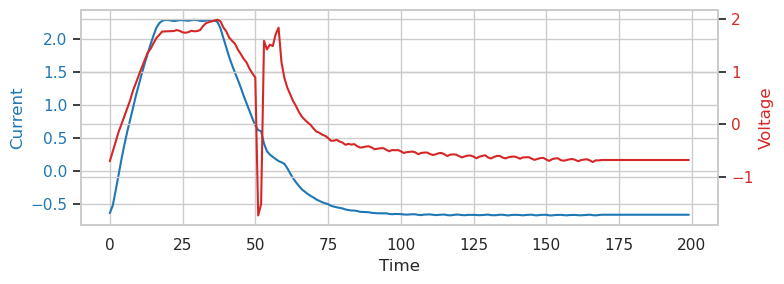

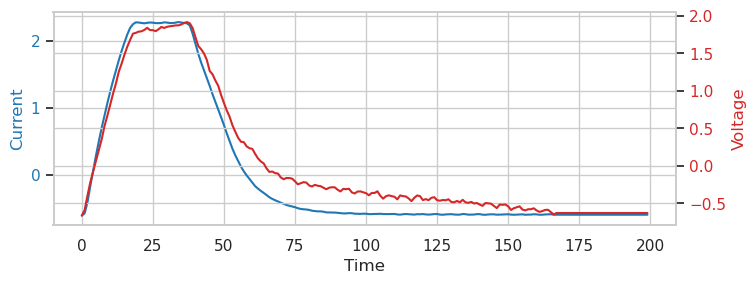

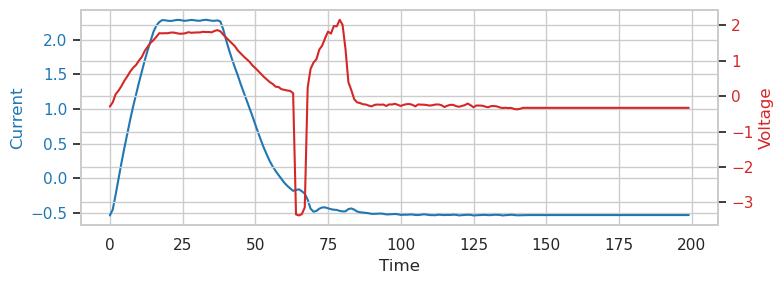

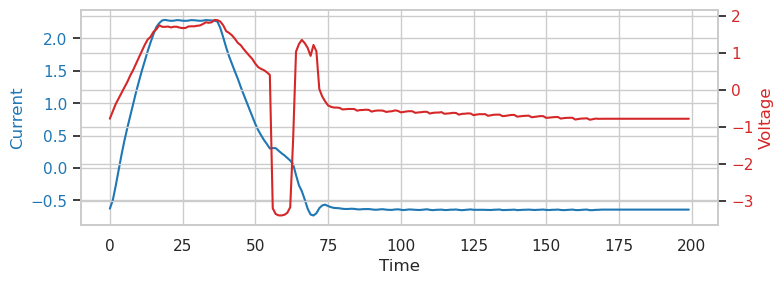

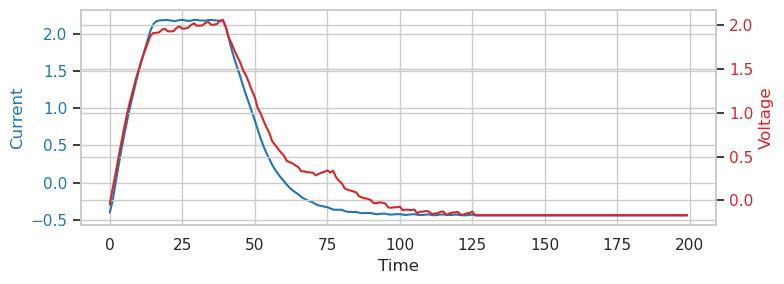

In [24]:
def print_cycle(test_ids):
    batch_size=512
    val_ids = (tuple(list(test_ids)[0]),)
    test_ids = tuple(list(test_ids)[1:])
    val_ids = [DataSplitId(experiment=e, welding_run=w) for e, w in val_ids]
    test_ids = [DataSplitId(experiment=e, welding_run=w) for e, w in test_ids]
    data_module = ASIMoWDataModule(
        task="reconstruction",
        batch_size=batch_size,
        n_cycles=1,
        val_data_ids=val_ids,
        test_data_ids=test_ids,
    )
    data_module.setup(stage="fit")
    test_data = data_module.test_ds
    count = 0
    for sample in test_data:
        sample = pd.DataFrame(sample)
        current = sample[1].to_numpy()
        voltage = sample[0].to_numpy()
        plot_current_voltage(
            current=current, 
            voltage=voltage, 
            title="",
            filename=f'cycle{count}.png',
            figsize=(8, 3),
            legend=False,
            path='images/final/'
        )
        count += 1
        if count == 5:
            break
# print_cycle(get_experiment_ids(1))